In [1]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try: 
            print(f'Shape:{var.shape}')
        except : 
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}') 

In [2]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

# **실습 1 : VGG Model Fine Tuning**

## **Import Module**

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from IPython import display

device ='cuda:0'
torch.__version__

'1.12.0+cu113'

## **Dataset**

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((48, 48)), ]) 
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# num_workers : how many subprocesses to use for data loading.
# 0 means that the data will be loaded in the main process.   

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [5]:
batch = next(iter(trainloader))
print(batch[0].shape, batch[1].shape)
print(batch[0][0].min(), batch[0][1].max())

torch.Size([128, 3, 48, 48]) torch.Size([128])
tensor(0.0003) tensor(0.9155)


torch.Size([128, 3, 48, 48]) torch.Size([128])  
tensor(0.0077) tensor(0.8297)

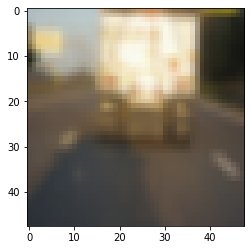

In [ ]:
plt.imshow(batch[0][0].permute(1, 2, 0)) 

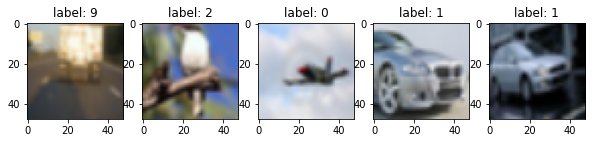

In [ ]:
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(batch[0][i].permute(1, 2, 0))
    plt.title(f'label: {batch[1][i]}')
plt.show()  

## **Load VGG16 model**

In [6]:
vgg16 = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [7]:
p(vgg16,'cr')
p(vgg16.features,'cr')  
vgg16_ = vgg16.features  

Type: <class 'torchvision.models.vgg.VGG'>
Values: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPo

In [ ]:
summary(vgg16, input_size=(16, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [16, 1000]                --
├─Sequential: 1-1                        [16, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [16, 64, 48, 48]          1,792
│    └─ReLU: 2-2                         [16, 64, 48, 48]          --
│    └─Conv2d: 2-3                       [16, 64, 48, 48]          36,928
│    └─ReLU: 2-4                         [16, 64, 48, 48]          --
│    └─MaxPool2d: 2-5                    [16, 64, 24, 24]          --
│    └─Conv2d: 2-6                       [16, 128, 24, 24]         73,856
│    └─ReLU: 2-7                         [16, 128, 24, 24]         --
│    └─Conv2d: 2-8                       [16, 128, 24, 24]         147,584
│    └─ReLU: 2-9                         [16, 128, 24, 24]         --
│    └─MaxPool2d: 2-10                   [16, 128, 12, 12]         --
│    └─Conv2d: 2-11                      [16, 256, 12, 12]         29

In [ ]:
summary(vgg16_, input_size=(16, 3, 48, 48))  

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 512, 1, 1]           --
├─Conv2d: 1-1                            [16, 64, 48, 48]          1,792
├─ReLU: 1-2                              [16, 64, 48, 48]          --
├─Conv2d: 1-3                            [16, 64, 48, 48]          36,928
├─ReLU: 1-4                              [16, 64, 48, 48]          --
├─MaxPool2d: 1-5                         [16, 64, 24, 24]          --
├─Conv2d: 1-6                            [16, 128, 24, 24]         73,856
├─ReLU: 1-7                              [16, 128, 24, 24]         --
├─Conv2d: 1-8                            [16, 128, 24, 24]         147,584
├─ReLU: 1-9                              [16, 128, 24, 24]         --
├─MaxPool2d: 1-10                        [16, 128, 12, 12]         --
├─Conv2d: 1-11                           [16, 256, 12, 12]         295,168
├─ReLU: 1-12                             [16, 256, 12, 12]      

### **마지막 `conv block`만 남기고 나머지는 전부 freeze**   
- ### 마지막 conv block이 fine tuning 됨 

In [16]:
list(vgg16_.children())

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1

In [ ]:
vgg16_ = vgg16.features
for i, child in enumerate(vgg16_.children()):
  if i < len(vgg16_) - 7:
    # Freeze the layers except the last 7 layers
    for param in child.parameters():
      param.requires_grad = False
  else : 
    print(child)  

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
for child in vgg16_.children():
    for param in child.parameters():
        print(child, param.requires_grad)
        break  

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True


In [ ]:
summary(vgg16_, input_size=(16, 3, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 512, 1, 1]           --
├─Conv2d: 1-1                            [16, 64, 48, 48]          (1,792)
├─ReLU: 1-2                              [16, 64, 48, 48]          --
├─Conv2d: 1-3                            [16, 64, 48, 48]          (36,928)
├─ReLU: 1-4                              [16, 64, 48, 48]          --
├─MaxPool2d: 1-5                         [16, 64, 24, 24]          --
├─Conv2d: 1-6                            [16, 128, 24, 24]         (73,856)
├─ReLU: 1-7                              [16, 128, 24, 24]         --
├─Conv2d: 1-8                            [16, 128, 24, 24]         (147,584)
├─ReLU: 1-9                              [16, 128, 24, 24]         --
├─MaxPool2d: 1-10                        [16, 128, 12, 12]         --
├─Conv2d: 1-11                           [16, 256, 12, 12]         (295,168)
├─ReLU: 1-12                             [16, 256, 12,

### **VGG 결과를 받아 Flatten + BN + ReLU + Linear를 추가하여 classification model 완성**
- ***batch normalizatin을 필히 사용할 것***

In [ ]:
loss_function = nn.CrossEntropyLoss()

class VGGFineTune(LightningModule):
    def __init__(self, vggnet, num_classes=10):
        super(VGGFineTune, self).__init__()
        self.features = vggnet
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x) 
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

vggFineTune = VGGFineTune(vgg16_, 10)
summary(vggFineTune, input_size=(batch_size, 3, 48, 48))  

Layer (type:depth-idx)                   Output Shape              Param #
VGGFineTune                              [128, 10]                 --
├─Sequential: 1-1                        [128, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [128, 64, 48, 48]         (1,792)
│    └─ReLU: 2-2                         [128, 64, 48, 48]         --
│    └─Conv2d: 2-3                       [128, 64, 48, 48]         (36,928)
│    └─ReLU: 2-4                         [128, 64, 48, 48]         --
│    └─MaxPool2d: 2-5                    [128, 64, 24, 24]         --
│    └─Conv2d: 2-6                       [128, 128, 24, 24]        (73,856)
│    └─ReLU: 2-7                         [128, 128, 24, 24]        --
│    └─Conv2d: 2-8                       [128, 128, 24, 24]        (147,584)
│    └─ReLU: 2-9                         [128, 128, 24, 24]        --
│    └─MaxPool2d: 2-10                   [128, 128, 12, 12]        --
│    └─Conv2d: 2-11                      [128, 256, 12, 12]  

## **Fit**

In [ ]:
%%time
vggFineTune = VGGFineTune(vgg16_, 10)

epochs=10
logger = CSVLogger("logs", name="VGGNetFineTune")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(vggFineTune, trainloader, val_dataloaders=testloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/VGGNetFineTune
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | features   | Sequential | 14.7 M
1 | classifier | Sequential | 6.2 K 
------------------------------------------
7.1 M     Trainable params
7.6 M     Non-trainable params
14.7 M    Total params
58.883    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

CPU times: user 2min 4s, sys: 10.2 s, total: 2min 15s
Wall time: 3min


Epoch 9: 100%  
470/470 [00:23<00:00, 20.18it/s, loss=0.0535, v_num=3]  
CPU times: user 2min 9s, sys: 14.3 s, total: 2min 24s  
Wall time: 3min 55s

In [ ]:
v_num = vggFineTune.get_progress_bar_dict()['v_num']

history = pd.read_csv(f'./logs/VGGNetFineTune/version_{v_num}/metrics.csv')
history_plot = history.drop('step', axis=1).groupby('epoch').mean()

In [ ]:
np.max(history_plot['val_acc'])

0.8241999745368958

0.8202000260353088


## **Analysis**

In [ ]:
def plot_history1(history):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.title('Accuray')
    plt.plot( history['acc'], 'b--', label='acc')
    plt.plot( history['val_acc'], 'r', label='val_acc')
    plt.grid(True)
#    plt.ylim([0.6, 1])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Loss')
    plt.plot( history['loss'], 'b--', label='loss')
    plt.plot( history['val_loss'], 'r', label='val_loss')
    plt.grid(True)
    #plt.ylim([0.0, 0.6])
    plt.legend()
    plt.show()

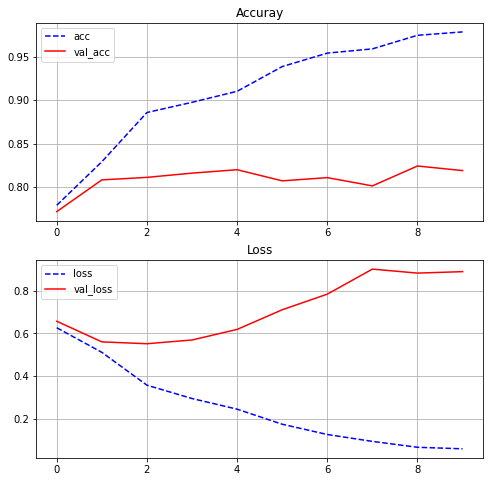

In [ ]:
np.max(history_plot['val_acc'])
plot_history1(history_plot)

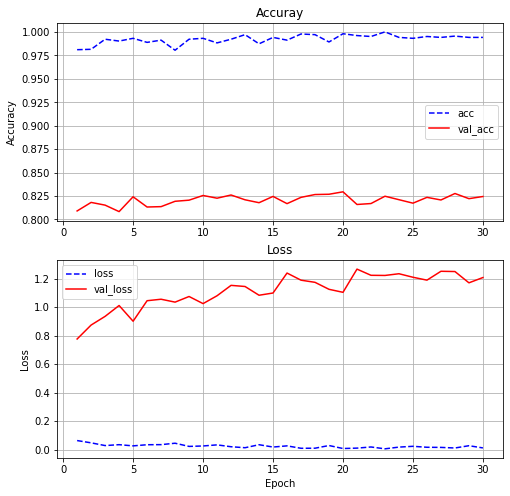

## **Prediction result with test image**

In [ ]:
# testset[i] : (image, label)  
testset[10][0].unsqueeze(dim=0).shape 

torch.Size([1, 3, 48, 48])

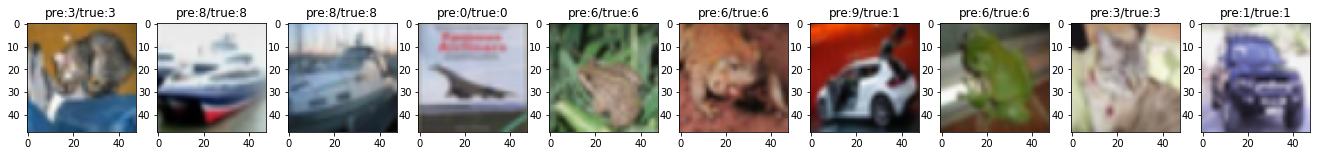

In [ ]:
n_index = 0
n_plot = 10
plt.figure(figsize=(2.3*n_plot, n_plot))
vggFineTune.eval() # Trainable = False
for i in range(n_plot):
    img_idx = n_index+i
    predict = vggFineTune(testset[img_idx][0].unsqueeze(dim=0))\
                                         .cpu().detach().numpy()
    img = testset[img_idx][0].permute(1, 2, 0)
    plt.subplot(1,n_plot,i+1)
    plt.imshow(img, cmap='gray') 
    plt.title('pre:{}/true:{}'.format(np.argmax(predict),testset[img_idx][1]))

plt.show()